In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import napari

from datetime import datetime
from tqdm.notebook import tqdm
from napari_animation import Animation

# Data location & settings

In [ ]:
# Paths
path_base = "[repo]/sampleData/"

# These paths should be present within the base directory
path_img = path_base + "/Image/"
path_track = path_base + "/Tracks/"
path_movies = path_base + "/Movies/"

# Name of imaging dataset
filename = "sample.npy"

In [ ]:
# Crop buffer size in pixels
buffer = 100

# Load imaging data

In [ ]:
'''
Load stitch
Axis: [t, c, y, x]
'''
data_img = np.load(path_img + filename, mmap_mode = 'r') #enabled lazy loading by default
print(data_img.shape)

# Load tracking data

In [ ]:
'''
Load tracking data
Columns: [t, y, x, IDTrack]
'''

df_tracks = pd.read_csv(path_track + filename[:-4] + "_tracks.csv", sep = ",", decimal = ".")
print(df_tracks.tail())

# Track inclusion

In [ ]:
# Set threshold for minimum length of tracks to include (0 = no limit)
length_limit = df_tracks['t'].max() * .7

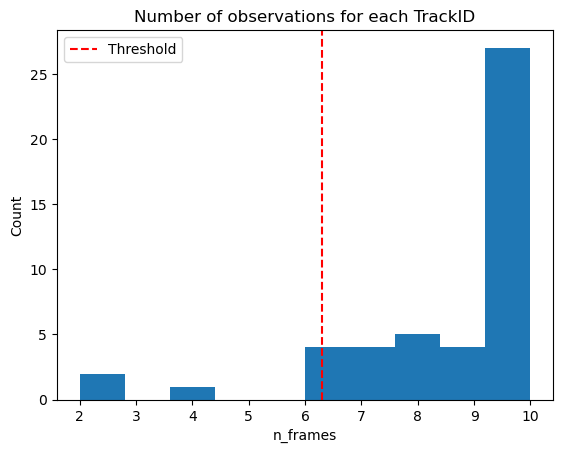

In [55]:
# Plot track length distribution as sanity check
track_lengths = df_tracks.groupby(['IDTrack']).size().reset_index(name = 'count')

# Plot the histogram
plt.hist(track_lengths['count'])
plt.xlabel('n_frames')
plt.axvline(x = length_limit, color = 'red', linestyle = '--', label = 'Threshold')
plt.ylabel('Count')
plt.title('Number of observations for each TrackID')
plt.legend()
plt.show()

In [ ]:
# Select Track IDs that meet length criteria, reindex for later reference in cropped stack
tracks_of_interest = track_lengths[track_lengths['count'] >= length_limit][['IDTrack']].reset_index(drop = True).reset_index()
tracks_of_interest.to_csv(path_movies + filename + '_StabilizedIndex.csv', index = False)

In [ ]:
# Filter tracking table, and associate reindexed track IDs
df_tracks_filter = df_tracks.merge(tracks_of_interest, on = ['IDTrack'])
print('event percent retained', round(len(df_tracks_filter)/len(df_tracks)*100, 2), '%')

In [ ]:
# Build crop & padding table
img_width = data_img.shape[-1]
img_height = data_img.shape[-2]

df_tracks_filter['x_int'] = df_tracks_filter['x'].round(0).astype(int)
df_tracks_filter['y_int'] = df_tracks_filter['y'].round(0).astype(int)

# calculate min and max X and Y by buffer from track centroid
df_tracks_filter['x_min'] = df_tracks_filter['x_int'] - buffer
df_tracks_filter['x_max'] = df_tracks_filter['x_int'] + buffer
df_tracks_filter['y_min'] = df_tracks_filter['y_int'] - buffer
df_tracks_filter['y_max'] = df_tracks_filter['y_int'] + buffer

# calculate padding pixels in X and Y
df_tracks_filter['pad_left'] = np.abs(np.clip(df_tracks_filter['x_min'], None, 0))
df_tracks_filter['pad_right'] = np.abs(np.clip(df_tracks_filter['x_max'] - img_width, 0, None))
df_tracks_filter['pad_top'] = np.abs(np.clip(df_tracks_filter['y_min'], None, 0))
df_tracks_filter['pad_bottom'] = np.abs(np.clip(df_tracks_filter['y_max'] - img_height, 0, None))

# clip min and max to image dims
df_tracks_filter['x_min'] = np.clip(df_tracks_filter['x_min'], 0, None)
df_tracks_filter['y_min'] = np.clip(df_tracks_filter['y_min'], 0, None)
df_tracks_filter['x_max'] = np.clip(df_tracks_filter['x_max'], None, img_width)
df_tracks_filter['y_max'] = np.clip(df_tracks_filter['y_max'], None, img_height)

print(df_tracks_filter.tail())

In [ ]:
# Init empty np array to paste data in
sizes_stab = {
    'T': data_img.shape[0],
    'P': len(tracks_of_interest),
    'C': data_img.shape[1],
    'X': buffer * 2,
    'Y': buffer * 2}
print(sizes_stab)

stabilized_movie_img = np.zeros(shape = list(sizes_stab.values()), dtype = np.uint16)

In [ ]:
# Sort crop table (moe efficient with lazy timeframe loading) 
crop_table = df_tracks_filter.sort_values(by = ['t']).reset_index(drop = True)
crop_table_np = crop_table[['index', 't', 'x_min', 'x_max', 'y_min', 'y_max', 'pad_left', 'pad_right', 'pad_top', 'pad_bottom']].to_numpy()

In [ ]:
# Crop imaging data and paste into np array according to crop table
last_T = None

for i in tqdm(crop_table_np):
    index, T = i[:2]

    # slice T
    if (T != last_T):
        img = data_img[T]
        
        # set which T and P last computed
        last_T = T

    # Crop parameters
    x_min, x_max, y_min, y_max = i[-8:-4]
    pad_left, pad_right, pad_top, pad_bottom = i[-4:]
    
    # Crop (all channels)
    crop = img[:, y_min:y_max, x_min:x_max]
    
    # pad tile image if required
    if (np.sum(i[-4:]) > 0):
        pad_tuple = ((0, 0), (pad_top, pad_bottom), (pad_left, pad_right))
        crop = np.pad(crop, pad_tuple, mode = 'constant')

    # paste tile image
    stabilized_movie_img[T, index] = crop

# Store array to disk
np.save(path_movies + filename + "_Stabilized.npy", stabilized_movie_img)

# Napari (individual tracks)

In [ ]:
viewer = napari.Viewer()

In [ ]:
if 'stabilized_movie_img' not in locals():
    stabilized_movie_img = np.load(path_movies + filename + "_Stabilized.npy")
print(stabilized_movie_img.shape())

In [ ]:
# load image movie
layerImage = viewer.add_image(stabilized_movie_img,
                 channel_axis = 2,
                 blending = 'additive',
                 visible = True,
                 gamma = 1)
viewer.dims.axis_labels = ['T', 'Object', 'Y', 'X']

# Make into grid

In [ ]:
def assign_grid_positions(df, grid_shape):
    num_rows, num_cols = grid_shape
    total_elements = num_rows * num_cols

    # Calculate row and column numbers for each row
    df['Row'] = (df.index // num_cols) % num_rows
    df['Column'] = df.index % num_cols

    return df

In [ ]:
# Reload in case of making a new grid in a new session
if 'tracks_of_interest' not in locals():
    tracks_of_interest = pd.read_csv(path_movies + filename + '_StabilizedIndex.csv')

### Pick A (random subset) or B (specific subset)

In [ ]:
# A. Select random tracks
tracks_of_interest_sample = tracks_of_interest.sample(n = 5*5*5).reset_index(drop = True)
print(tracks_of_interest_sample)

In [ ]:
# B. Select specific tracks
tracksOfInterest = range(9)
tracks_of_interest_sample = tracks_of_interest[tracks_of_interest['IDTrack'].isin(tracksOfInterest)].reset_index(drop = True)
print(tracks_of_interest_sample)

In [ ]:
# Define single grid dimensions
rows, cols = [3, 3]
grid_n = rows * cols

In [ ]:
# Assign tracks to position in grid and pages (sets) if overflowing 1 grid
tracks_of_interest_sample['set'] = [i // grid_n for i in range(len(tracks_of_interest_sample))]
tracks_of_interest_sample = assign_grid_positions(tracks_of_interest_sample, (rows, cols))

# Assign track pixel positions in grid
tracks_of_interest_sample['x_start'] = tracks_of_interest_sample['Column'] * 2 * buffer
tracks_of_interest_sample['x_stop'] = tracks_of_interest_sample['Column'] * 2* buffer + 2 * buffer
tracks_of_interest_sample['y_start'] = tracks_of_interest_sample['Row'] * 2 * buffer
tracks_of_interest_sample['y_stop'] = tracks_of_interest_sample['Row'] * 2* buffer + 2 * buffer

# Store grid layout table
tracks_of_interest_sample.to_csv(path_movies + filename + '_StabilizedGridIndex.csv', index = False)
print(tracks_of_interest_sample.tail())

In [ ]:
# Initiate empty numpy array for grid
shapeIn = stabilized_movie_img.shape
shapeGridAll = [shapeIn[0], #T
                tracks_of_interest_sample['set'].max() + 1, #ObjectIndex
                shapeIn[2], #Channels
                rows * buffer * 2,
                cols * buffer * 2]
stabilized_movie_img_grid = np.zeros(shape = shapeGridAll, dtype = np.uint16)
stabilized_movie_img_grid.shape

In [ ]:
# Paste single object movies at calculated positions in grid
tracks_of_interest_sample_np = tracks_of_interest_sample[['index', 'set', 'Row', 'Column', 'y_start', 'y_stop', 'x_start', 'x_stop']].to_numpy()
for i in tqdm(tracks_of_interest_sample_np):
    index, Set, Row, Column, y_start, y_stop, x_start, x_stop = i
    
    # isolate cell (all T & C)
    img = stabilized_movie_img[:, index]
    # paste
    stabilized_movie_img_grid[:, Set, :, y_start:y_stop, x_start:x_stop] = img

# Store array to disk
np.save(path_movies + filename + "_Stabilized_grid_subset.npy", stabilized_movie_img_grid)

# Napari (grid)

In [ ]:
viewer = napari.Viewer()

In [ ]:
if 'stabilized_movie_img_grid' not in locals():
    stabilized_movie_img_grid = np.load(path_movies + filename + "_Stabilized_grid_subset.npy")
print(stabilized_movie_img_grid.shape())

In [ ]:
# load image movie
layerImage = viewer.add_image(stabilized_movie_img_grid,
                 channel_axis = 2,
                 blending = 'additive',
                 visible = True,
                 gamma = 1)
viewer.dims.axis_labels = ['T', 'Set', 'Y', 'X']

### Create annotated crop outlines (IDTrack)

In [ ]:
def make_bbox(bbox_extents):
    """Get the coordinates of the corners of a
    bounding box from the extents

    Parameters
    ----------
    bbox_extents : list (4xN)
        List of the extents of the bounding boxes for each of the N regions.
        Should be ordered: [min_row, min_column, max_row, max_column]

    Returns
    -------
    bbox_rect : np.ndarray
        The corners of the bounding box. Can be input directly into a
        napari Shapes layer.
    """
    minr = bbox_extents[0]
    minc = bbox_extents[1]
    maxr = bbox_extents[2]
    maxc = bbox_extents[3]

    bbox_rect = np.array(
        [[minr, minc], [maxr, minc], [maxr, maxc], [minr, maxc]]
    )
    bbox_rect = np.moveaxis(bbox_rect, 2, 0)

    return bbox_rect

In [ ]:
if 'stabilized_movie_img_grid' not in locals():
   tracks_of_interest_sample = pd.read_csv(path_movies + filename + '_StabilizedGridIndex.csv', index = False)

In [ ]:
# make tile position + index layer (rect + text)
features_tiles = {
    'label': 'ID' + tracks_of_interest_sample['IDTrack'].astype(str).str.zfill(4),
    'bbox-0': tracks_of_interest_sample['y_start'],
    'bbox-1': tracks_of_interest_sample['x_start'],
    'bbox-2': tracks_of_interest_sample['y_stop'],
    'bbox-3': tracks_of_interest_sample['x_stop']
}

# Translate coordinates into bounding box
bbox_tile = make_bbox([features_tiles[f'bbox-{i}'] for i in range(4)])

# Append set axis for display
bbox_tile = [np.concatenate((np.tile([tracks_of_interest_sample.loc[i, 'set']], (4, 1)), bbox), axis = 1) for i, bbox in enumerate(bbox_tile)]

In [ ]:
# Specify the display parameters for the text
text_parameters = {
    'string': '{label}',
    'size': 12,
    'color': 'yellow',
    'anchor': 'upper_left',
    'translation': [0, 0],
    'opacity': 1
}

shapes_layer = viewer.add_shapes(
    bbox_tile,
    face_color = 'transparent',
    edge_color = 'yellow',
    edge_width = 2,
    properties = features_tiles,
    text = text_parameters,
    name = 'bbox_index',
    opacity = 0.75
)

### Render animation of grid from Napari

In [ ]:
# Initiate animation
animation = Animation(viewer)

In [ ]:
# First keyframe (start of timelapse)
viewer.dims.set_current_step(0, 0)
animation.capture_keyframe()

In [ ]:
# Last keyframe (end of timelapse)
length_movie = stabilized_movie_img_grid.shape[0]
viewer.dims.set_current_step(0, length_movie)
animation.capture_keyframe(steps = length_movie)

In [ ]:
# Render command
animation.animate(path_movies + datetime.today().strftime('%Y%m%d') + '_GridMovie.mov', canvas_only = True, quality = 9, fps = 10)